# %% [markdown]
# # Factor Analysis Notebook
# 
# ## Objective
# This notebook applies two key concepts from our research paper to our existing data:
# 1.  **Stationarity Testing (Section 7.2)**: We will use the Augmented Dickey-Fuller (ADF) test to check if our engineered factors are stationary.
# 2.  **Market Memory Analysis (Section 3.1)**: We will calculate the Hurst Exponent to determine if our price series is trending, mean-reverting, or random.


In [4]:
# --- SETUP: Load Libraries and Data ---
import pandas as pd
import numpy as np
from pathlib import Path
from statsmodels.tsa.stattools import adfuller
from hurst import compute_Hc
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
print("Libraries imported.")

# Load the processed data for a sample stock (AAPL)
processed_data_path = Path("../data/processed/AAPL_processed.csv")
df = pd.read_csv(processed_data_path, index_col='Date', parse_dates=True)

print("Sample data for AAPL loaded.")
# Print the column names to confirm what we have
print("\nColumns in the DataFrame:")
print(df.columns)

df.head()

Libraries imported.
Sample data for AAPL loaded.

Columns in the DataFrame:
Index(['Open', 'High', 'Low', 'Close', 'Volume', 'RSI', 'MACD', 'MACD_signal',
       'EMA_20', 'EMA_50', 'EMA_200'],
      dtype='object')


,Open,High,Low,Close,Volume,RSI,MACD,MACD_signal,EMA_20,EMA_50,EMA_200
Date,,,,,,,,,,,
2010-10-18,9.557230,9.587283,9.445728,9.571355,1093010800,81.910318,0.309252,0.260001,8.769204,8.339134,7.574262
2010-10-19,9.301470,9.430101,9.016857,9.118440,1232784000,62.607003,0.298920,0.267785,8.802464,8.369695,7.589627
2010-10-20,9.332726,9.444528,9.222729,9.286744,721624400,65.829591,0.300844,0.274397,8.848586,8.405658,7.606513
2010-10-21,9.302373,9.459255,9.220625,9.387726,551460000,67.632058,0.306979,0.280913,8.899933,8.444170,7.624237
2010-10-22,9.240760,9.317999,9.205597,9.288846,372778000,64.068299,0.300400,0.284810,8.936972,8.477295,7.640800


## 1. Stationarity Analysis (ADF Test)

A time series is **stationary** if its statistical properties (like mean and variance) are constant over time. This is a crucial assumption for most predictive models.

The **Augmented Dickey-Fuller (ADF) Test** is a statistical test for stationarity. The key result is the **p-value**:
- **p-value <= 0.05**: We reject the null hypothesis. The data is **likely stationary**.
- **p-value > 0.05**: We fail to reject the null hypothesis. The data is **likely non-stationary**.

In [5]:
# --- Run ADF Test on All Factors ---

# We exclude columns that are not factors or are known to be non-stationary (like prices or EMAs)
factors_to_test = df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'EMA_20', 'EMA_50', 'EMA_200']).columns

print("--- ADF Test for Stationarity ---")
for factor in factors_to_test:
    result = adfuller(df[factor].dropna())
    p_value = result[1]
    
    if p_value <= 0.05:
        print(f"'{factor}' is likely STATIONARY (p-value: {p_value:.4f})")
    else:
        print(f"'{factor}' is likely NON-STATIONARY (p-value: {p_value:.4f})")

--- ADF Test for Stationarity ---
'RSI' is likely STATIONARY (p-value: 0.0000)
'MACD' is likely STATIONARY (p-value: 0.0000)
'MACD_signal' is likely STATIONARY (p-value: 0.0000)


## 2. Market Memory Analysis (Hurst Exponent)

The **Hurst Exponent (H)** measures the "memory" of a time series. It tells us if the series is characterized by trends, mean-reversion, or randomness.

- **H < 0.5**: The series is **mean-reverting** (a positive move is likely followed by a negative one).
- **H = 0.5**: The series is a **random walk**.
- **H > 0.5**: The series is **trending** (a positive move is likely followed by another positive one).

In [6]:
# --- Calculate Hurst Exponent for the Price Series ---

# We use the 'Close' price series for this analysis
price_series = df['Close']

# Calculate Hurst Exponent for the entire series
H, c, data = compute_Hc(price_series, kind='price', simplified=True)

print(f"--- Hurst Exponent for AAPL Close Price (Full Period) ---")
print(f"H = {H:.4f}")

if H < 0.5:
    print("Interpretation: The series appears to be mean-reverting over the full period.")
elif H > 0.5:
    print("Interpretation: The series appears to be trending over the full period.")
else:
    print("Interpretation: The series appears to be a random walk over the full period.")

--- Hurst Exponent for AAPL Close Price (Full Period) ---
H = 0.9327
Interpretation: The series appears to be trending over the full period.


### Rolling Hurst Exponent
A single Hurst value for the entire history is interesting, but markets change. A **rolling Hurst exponent** is much more useful, as it shows how the market's memory evolves over time.

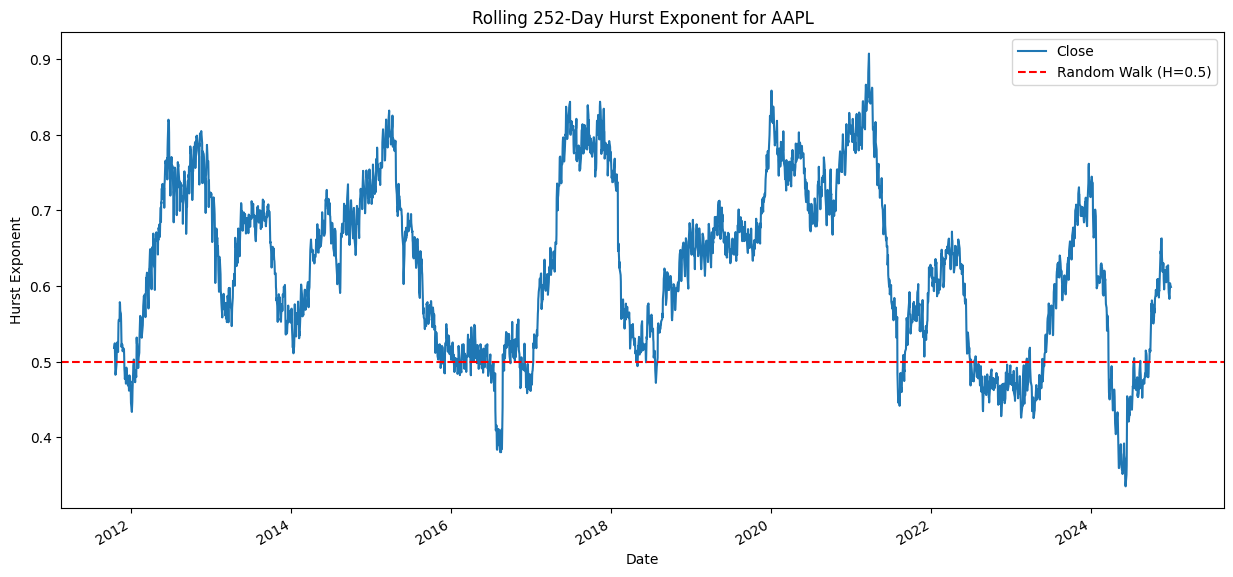

In [7]:
# --- Calculate Rolling Hurst Exponent ---

# This is computationally intensive and can take a minute
window = 252 # Approximately one year of trading days
rolling_H = price_series.rolling(window=window).apply(lambda x: compute_Hc(x, kind='price')[0], raw=True)

# Plot the rolling Hurst exponent
rolling_H.plot(figsize=(15, 7), title='Rolling 252-Day Hurst Exponent for AAPL')
plt.axhline(0.5, color='red', linestyle='--', label='Random Walk (H=0.5)')
plt.ylabel("Hurst Exponent")
plt.legend()
plt.show()